In [1]:
# Przygotowanie środowiska
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [34]:
# Globalne zmienne
r = 0.04  # stopa zwrotu z IKE
inflacja = 0.025
belka = 0.19
podatek_od_prywatyzacji = 0.15
stawka_pit = 0.17  # na emeryturze
waloryzacja_emerytur = inflacja + 0.2*0.04  # oficjalna inflacja + 20% realnego wzrostu gospodarczego

# Zmienna dla konkretnego przypadku
prognozowana_emerytura_brutto = 1900
skladka_zdrowotna = prognozowana_emerytura_brutto * 0.09
zaliczka_pit = prognozowana_emerytura_brutto * stawka_pit - 556.02/12 - prognozowana_emerytura_brutto * 0.0775
prognozowana_emerytura_netto = prognozowana_emerytura_brutto - skladka_zdrowotna - zaliczka_pit
efektywna_stawka_opodatkowania = 1 - prognozowana_emerytura_netto / prognozowana_emerytura_brutto

# TODO zmienny efektywny pit - (inflacja rośnie, to podatek się zmienia)
ofe = 11500 
do_emerytury = 13
lat_na_emeryturze = 18+5  # https://www.money.pl/emerytury/emerytury-gus-ma-jednoczesnie-dobra-i-zla-wiadomosc-dane-dotycza-sredniej-dlugosci-zycia-6363469538014849a.html
oczekiwana_dlugosc_zycia = 77 # https://stat.gov.pl/obszary-tematyczne/ludnosc/trwanie-zycia/trwanie-zycia-w-2018-r-,2,13.html
oczekiwana_liczba_lat_na_emeryturze = oczekiwana_dlugosc_zycia - 65

Text(0.5, 1.0, 'Stopy waloryzacji kapitału zgromadzonego w ZUS')

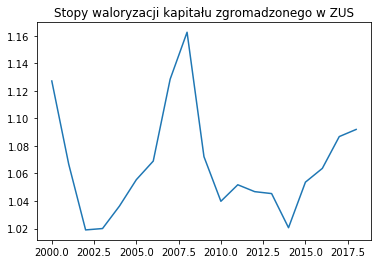

In [27]:
# Historyczne wartości waloryzacji kapitału zgromadzonego w ZUS
hist_waloryzacja = [1.1272, 1.0668, 1.0190, 1.0200, 1.0363, 1.0555, 1.0690, 1.1285, 1.1626, 1.0722, 1.0398, 1.0518, 1.0468, 1.0454, 1.0206, 1.0537, 1.0637, 1.0868, 1.0920]
mean_hist_waloryzacja = np.mean(hist_waloryzacja)
q40_hist_waloryzacja = np.quantile(hist_waloryzacja, 0.4)
avg_geom_hist_waloryzacja = np.power(np.prod(hist_waloryzacja), 1/len(hist_waloryzacja))

plt.plot([int(x) for x in range(2000, 2019)], hist_waloryzacja)
plt.title('Stopy waloryzacji kapitału zgromadzonego w ZUS')

In [28]:
# Wariant 1: Prywatyzacja środków
# Etap 1: Do emerytury

# w 1. roku sprywatyzowania OFE wartość kapitału topnieje o 7.5%, reszta pracuje na inwestycji w ramach IKE bez podatku belki
# w 2. roku wartość kapitału topnieje o kolejne 7.5%, ale pracuje na inwestycji w ramach IKE bez podatku Belki
# w 3. i każdym kolejnym roku do emerytury wartość kapitału rośnie o oczekiwaną stopę zwrotu, bez podatku Belki
NPV_IKE = ofe * (1 - podatek_od_prywatyzacji/2) * (1+r) * (1 - podatek_od_prywatyzacji/2) * (1+r) * np.power((1+r), do_emerytury-2)

# W momencie wypłaty środków z IKE ich wartość nominalna jest wysoka, jednak wartość realna zjadana jest przez inflację, toteż wartość nominalna > realna. Deflator:
NPV_IKE = NPV_IKE / np.power((1+inflacja), do_emerytury)
print("Zgromadzony kapitał na IKE w momencie przejścia na emeryturę wynosi %d PLN na dzisiejsze pieniądze (po opodatkowaniu i w cenach z dzisiaj)" % NPV_IKE)

Zgromadzony kapitał na IKE w momencie przejścia na emeryturę wynosi 31204 PLN na dzisiejsze pieniądze (po opodatkowaniu i w cenach z dzisiaj)


In [29]:
# Etap 2: Po emeryturze
projekcja_IKE = pd.Series(range(1, lat_na_emeryturze + 1), name='rok_emerytury').to_frame()

NPV_IKE_dyn = NPV_IKE
NPV_IKE_list = list()
kapital_rok = list()

# Zakładamy, że na emeryturze kapitał pracuje nam na bezpiecznej lokacie (opodatkowanej podatkiem Belki)
for rok in range(lat_na_emeryturze):
    # Kapitał wypłacamy sobie proporcjonalnie do pozostałych lat na emeryturze - np. pozostało nam (statystycznie) 5 lat, więc wypłacamy sobie 1/5 tego co zostało
    kapital_rok.append(NPV_IKE_dyn / (lat_na_emeryturze - rok))
    # w międzyczasie, kapitał, który pozostał inwestujemy, ale zżera go nam też inflacja
    NPV_IKE_dyn = (NPV_IKE_dyn - NPV_IKE_dyn/(lat_na_emeryturze - rok)) * (1 + r*(1-belka)) / (1+inflacja)
    NPV_IKE_list.append(NPV_IKE_dyn)
    
projekcja_IKE['NPV_IKE'] = NPV_IKE_list
projekcja_IKE['kapital_rok'] = kapital_rok
projekcja_IKE['IKE_dodatek_emerytura'] = round(projekcja_IKE['kapital_rok']/12, 2)

print("Efekt wybrania prywatyzacji:")
print("W pierwszym roku emerytury zwiększy nam emeryturę o {} PLN".format(projekcja_IKE['IKE_dodatek_emerytura'].iloc[0]))
print("W {}. roku emerytury zwiększy nam emeryturę o {} PLN".format(projekcja_IKE.shape[0], projekcja_IKE['IKE_dodatek_emerytura'].iloc[projekcja_IKE.shape[0]-1]))
print("\n")
print("Jeśli umrzemy wcześniej niż średnia, wtedy niewykorzystany kapitał jest dziedziczony")
print("Jeśli przeżyjemy dłużej niż średnia, po wyczerpaniu środków z IKE emerytura wraca do bazowej wielkości")
print("\n")
print("Szanse: wyższy zwrot z inwestycji, niższa inflacja, zmiana zasad pobierania podatku Belki na bardziej korzystne dla konsumentów")
print("Zagrożenia: Ponowna grabież środków tym razem z IKE, kiepskie inwestycje, wysoka inflacja, podwyżka podatku Belki")
projekcja_IKE

Efekt wybrania prywatyzacji:
W pierwszym roku emerytury zwiększy nam emeryturę o 113.06 PLN
W 23. roku emerytury zwiększy nam emeryturę o 132.45 PLN


Jeśli umrzemy wcześniej niż średnia, wtedy niewykorzystany kapitał jest dziedziczony
Jeśli przeżyjemy dłużej niż średnia, po wyczerpaniu środków z IKE emerytura wraca do bazowej wielkości


Szanse: wyższy zwrot z inwestycji, niższa inflacja, zmiana zasad pobierania podatku Belki na bardziej korzystne dla konsumentów
Zagrożenia: Ponowna grabież środków tym razem z IKE, kiepskie inwestycje, wysoka inflacja, podwyżka podatku Belki


,rok_emerytury,NPV_IKE,kapital_rok,IKE_dodatek_emerytura
0,1,30063.371547,1356.722017,113.06
1,2,28904.031951,1366.516889,113.88
2,3,27726.385678,1376.382474,114.70
3,4,26530.228825,1386.319284,115.53
4,5,25315.355497,1396.327833,116.36
5,6,24081.557791,1406.408639,117.20
6,7,22828.625780,1416.562223,118.05
7,8,21556.347490,1426.789111,118.90
8,9,20264.508883,1437.089833,119.76
9,10,18952.893841,1447.464920,120.62


In [30]:
# Wariant 2: Przeniesienie środków do ZUS
# Etap 1: Do emerytury

# Środki z OFE zostają przekazane do ZUS, gdzie korzystają z corocznej waloryzacji kapitału, która historycznie była wysoka
# Zeszłoroczna waloryzacja była wyższa niż średnia
# Do obliczeń założymy konserwatywnie nie średnią, ani nie medianę (jeszcze niższa), tylko 40 percentyl tej wielkości od 2000 roku.
# Stopa waloryzacji jest pochodną rozwoju gospodarczego, założenie 40 percentyla to założenie o łagodnym, acz długotrwałym spowolnieniu gospodarczym.
# To jak najbardziej realne założenie, nieco gorsze od tego co wszyscy się spodziewamy. Na zapas.

# Środki z OFE zapisane są na konto w ZUS, są waloryzowane co roku, aż do momentu przejścia na emeryturę.
# Ich realna wartość będzie nieco zmniejszona przez inflację, co też jest uwzględnione
NPV_ZUS = ofe * np.power(q40_hist_waloryzacja, do_emerytury) / np.power((1+inflacja), do_emerytury)  #  * (1-efektywna_stawka_opodatkowania)

# Uwaga: od tego kapitału będzie trzeba zapłacić podatek
print("Zgromadzony kapitał na ZUS w momencie przejścia na emeryturę wynosi %d PLN na dzisiejsze pieniądze (przed opodatkowaniem)" % NPV_ZUS)

Zgromadzony kapitał na ZUS w momencie przejścia na emeryturę wynosi 40499 PLN na dzisiejsze pieniądze (przed opodatkowaniem)


In [31]:
# kontynuacja: co po emeryturze?
projekcja_ZUS = pd.Series(range(1, lat_na_emeryturze + 1), name='rok_emerytury').to_frame()

# Zakładamy, że na emeryturze kapitał już nie jest waloryzowany. Zamiast tego waloryzowana jest emerytura
# Waloryzacja emerytury historycznie była zauważalnie niższa niż waloryzacja kapitału, dlatego tutaj przyjmujemy znacznie mniejsze wartości
# Dobra wiadomość jest taka, że waloryzacja emerytury nie może być niższa niż stopa inflacji statystycznego gospodarstwa emerytów powiększona o chyba 20% wzrostu gospodarczego.

# Tutaj wracamy do wartości nominalnej, bo od niej liczy się podatek
NPV_ZUS_dyn = NPV_ZUS * np.power((1+inflacja), do_emerytury) 
NPV_ZUS_list = list()
kapital_rok = list()
for rok in range(lat_na_emeryturze):
    # Emerytura jest obliczona w taki sposób, że ZUS wypłaca nam nasz kapitał proporcjonalnie do pozostałych lat na emeryturze
    # tutaj używamy wartości nominalnych, by móc poprawnie wyliczyć efektywny PIT) A POTEM ponownie stosujemy deflator sprzed emerytury
    kapital_rok.append(NPV_ZUS_dyn / (lat_na_emeryturze - rok) * (1-efektywna_stawka_opodatkowania) / np.power((1+inflacja), do_emerytury))
    # w międzyczasie, kapitał, który pozostał inwestujemy, ale zżera go nam też inflacja
    NPV_ZUS_dyn = (NPV_ZUS_dyn - NPV_ZUS_dyn/(lat_na_emeryturze - rok)) * (1+waloryzacja_emerytur) / (1+inflacja)
    NPV_ZUS_list.append(NPV_ZUS_dyn)
    
projekcja_ZUS['NPV_ZUS'] = NPV_ZUS_list
projekcja_ZUS['kapital_rok'] = kapital_rok
projekcja_ZUS['ZUS_dodatek_emerytura'] = round(projekcja_ZUS['kapital_rok']/12, 2)

print("Efekt wybrania ZUSu:")
print("W pierwszym roku emerytury zwiększy nam emeryturę o {} PLN".format(projekcja_ZUS['ZUS_dodatek_emerytura'].iloc[0]))
print("W {}. roku emerytury zwiększy nam emeryturę o {} PLN".format(projekcja_ZUS.shape[0], projekcja_ZUS['ZUS_dodatek_emerytura'].iloc[projekcja_ZUS.shape[0]-1]))
print("\n")
print("Jeśli umrzemy wcześniej, wtedy niewykorzystany kapitał nie jest dziedziczony")
print("Jeśli przeżyjemy dłużej, po wyczerpaniu środków emerytura dalej jest waloryzowana o stopę nieco wyższą niż inflacja")
print("\n")
print("Szanse: podwyższenie kwoty wolnej od podatku, obniżenie PIT, przeciętny lub dobry rozwój gospodarki Polski")
print("Zagrożenia: Ustawowe obniżenie emerytur, zawieszenie lub zmiana zasad waloryzacji kapitału, problemy z ZUS")

projekcja_ZUS

Efekt wybrania ZUSu:
W pierwszym roku emerytury zwiększy nam emeryturę o 122.22 PLN
W 23. roku emerytury zwiększy nam emeryturę o 145.02 PLN


Jeśli umrzemy wcześniej, wtedy niewykorzystany kapitał nie jest dziedziczony
Jeśli przeżyjemy dłużej, po wyczerpaniu środków emerytura dalej jest waloryzowana o stopę nieco wyższą niż inflacja


Szanse: podwyższenie kwoty wolnej od podatku, obniżenie PIT, przeciętny lub dobry rozwój gospodarki Polski
Zagrożenia: Ustawowe obniżenie emerytur, zawieszenie lub zmiana zasad waloryzacji kapitału, problemy z ZUS


,rok_emerytury,NPV_ZUS,kapital_rok,ZUS_dodatek_emerytura
0,1,48756.403314,1466.675580,122.22
1,2,46903.443773,1478.122804,123.18
2,3,45018.589935,1489.659372,124.14
3,4,43101.456812,1501.285982,125.11
4,5,41151.655352,1513.003336,126.08
5,6,39168.792392,1524.812142,127.07
6,7,37152.470626,1536.713115,128.06
7,8,35102.288558,1548.706973,129.06
8,9,33017.840463,1560.794442,130.07
9,10,30898.716347,1572.976253,131.08


No handles with labels found to put in legend.


(0, 146.61800000000002)

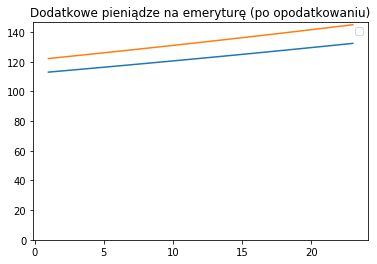

In [32]:
# Porównanie OFE->IKE vs. OFE->ZUS
plt.plot(projekcja_IKE['rok_emerytury'], projekcja_IKE['IKE_dodatek_emerytura'])
plt.plot(projekcja_IKE['rok_emerytury'], projekcja_ZUS['ZUS_dodatek_emerytura'])
plt.title('Dodatkowe pieniądze na emeryturę (po opodatkowaniu)')
plt.legend()
plt.ylim(0)

In [33]:
# Podsumowanie
suma_dodatku_od_IKE = sum(projekcja_IKE['IKE_dodatek_emerytura'])*12
suma_dodatku_od_ZUS = sum(projekcja_ZUS['ZUS_dodatek_emerytura'])*12

stosunek_ZUS_do_IKE = round((suma_dodatku_od_ZUS/suma_dodatku_od_IKE - 1)*100, 1)

if suma_dodatku_od_ZUS > suma_dodatku_od_IKE:
    print("Wybranie ZUS zaowocuje średnio o {}% wyższym dodatkiem do emerytury".format(stosunek_ZUS_do_IKE))
elif suma_dodatku_od_ZUS < suma_dodatku_od_IKE:
    print("Wybranie ZUS zaowocuje średnioo {}% niższym dodatkiem do emerytury".format(stosunek_ZUS_do_IKE))
else:
    print("ganz egal")

Wybranie ZUS zaowocuje średnio o 8.8% wyższym dodatkiem do emerytury
